# Classification of Promotable Chess Pieces

<center>
<img src="/notebooks/assets/img/promotionproblem.svg" width="80%" />
</center>

In this notebook, the goal is to use TensorFlow to train a convolutional neural network to classify images as either being a knight, bishop, rook, or queen. The goal is to use the model to determine which piece a player promoted their pawn to when playing against the [Raspberry Turk](http://www.raspberryturk.com). In most cases players will promote to a queen, so the robot could assume that, but there are [many examples](http://www.chessgames.com/perl/chesscollection?cid=1000028) when underpromotion is a better option.

In [1]:
import project
from raspberryturk.core.data.dataset import Dataset
import numpy as np
import tensorflow as tf
from random import randint

In [2]:
MAX_DISPLAY_STEP = 1000
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 10000
DROPOUT = 0.5
START_BATCH_SIZE = 5
END_BATCH_SIZE = 100

## Data

This dataset, `dataset7.npz`, was created using [`create_dataset.py`](https://bitbucket.org/joeymeyer/raspberryturk). It includes 19,968 ZCA whitened grayscale images of only promotable pieces.

In [3]:
d = Dataset.load_file(project.path('data', 'processed', 'dataset7.npz'))

In [4]:
labels_count = d.y_train.shape[1]
image_size = 3600
image_width = 60
image_height = 60
labels = ['Knight', 'Bishop', 'Rook', 'Queen']

In [5]:
train_images = d.X_train
train_labels = d.y_train
validation_images = d.X_val
validation_labels = d.y_val

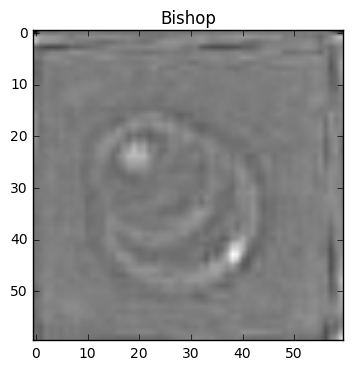

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
piece_index = 0
img = train_images[piece_index].reshape(image_width, image_height)
plt.title(labels[train_labels[piece_index].argmax()])
plt.imshow(img, cmap=cm.gray)
plt.show()

## Model

The model consists of 2 convolutional layers, each with using ReLU activation function and a max pool layer after each one. This is followed by a fully connected layer with 1024 hidden units, and finally a softmax layer. Dropout is used for regularization, and loss is defined as the cross entropy between the prediction label vector and the correct label vector.  

In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [8]:
x = tf.placeholder('float', shape=[None, image_size])
y_ = tf.placeholder('float', shape=[None, labels_count])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

image = tf.reshape(x, [-1, image_width, image_height, 1])

h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([15 * 15 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 15 * 15 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = -tf.reduce_sum(y_*tf.log(y))

train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

predict = tf.argmax(y, 1)

## Batching

Use stocastic gradient descent for faster training.

In [9]:
epochs_completed = 0
index_in_epoch = 0
num_examples = d.X_train.shape[0]

def next_batch(batch_size):
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > num_examples:
        epochs_completed += 1
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

## Training

Begin training, output the training/validation error at each display step.

In [10]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)
saver = tf.train.Saver()

In [11]:
train_accuracies = []
validation_accuracies = []
x_range = []

display_step = 10

previous_best = 0.0
for i in range(TRAINING_ITERATIONS):
    batch_size = int((END_BATCH_SIZE - START_BATCH_SIZE) * float(i) / TRAINING_ITERATIONS) + 5
    batch_xs, batch_ys = next_batch(batch_size)
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs,
                                                  y_: batch_ys,
                                                  keep_prob: 1.0})
        val_len = 1000
        ind = randint(0, validation_images.shape[0] - val_len - 1)
        val_images_batch = validation_images[ind:ind+val_len]
        val_labels_batch = validation_labels[ind:ind+val_len]
        validation_accuracy = accuracy.eval(feed_dict={x: val_images_batch,
                                                       y_: val_labels_batch,
                                                       keep_prob: 1.0})
        
        print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        x_range.append(i)
        if validation_accuracy > previous_best:
            previous_best = validation_accuracy
        if i%(display_step*10) == 0 and i:
            display_step = min(MAX_DISPLAY_STEP, display_step * 10)
            
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})
print("Finished training, best batch validation model accuracy: %.5f"%(previous_best))

training_accuracy / validation_accuracy => 0.60 / 0.24 for step 0
training_accuracy / validation_accuracy => 0.20 / 0.23 for step 10
training_accuracy / validation_accuracy => 0.40 / 0.26 for step 20
training_accuracy / validation_accuracy => 0.40 / 0.28 for step 30
training_accuracy / validation_accuracy => 0.00 / 0.29 for step 40
training_accuracy / validation_accuracy => 0.40 / 0.24 for step 50
training_accuracy / validation_accuracy => 0.00 / 0.28 for step 60
training_accuracy / validation_accuracy => 0.20 / 0.26 for step 70
training_accuracy / validation_accuracy => 0.40 / 0.29 for step 80
training_accuracy / validation_accuracy => 0.00 / 0.27 for step 90
training_accuracy / validation_accuracy => 0.40 / 0.28 for step 100
training_accuracy / validation_accuracy => 0.17 / 0.31 for step 200
training_accuracy / validation_accuracy => 0.43 / 0.30 for step 300
training_accuracy / validation_accuracy => 0.38 / 0.30 for step 400
training_accuracy / validation_accuracy => 0.22 / 0.31 for 

## Validation

Determine validation accuracy for the trained model, and produce a confusion matrix to visualize the effectiveness of training for the task of classification.

In [12]:
pred = sess.run(predict, feed_dict={x: validation_images, keep_prob: 1.0})

full_validation_accuracy = accuracy.eval(feed_dict={x: validation_images,
                                                    y_: validation_labels,
                                                    keep_prob: 1.0})
print "Validation accuracy: %.5f" % (full_validation_accuracy)

Validation accuracy: 0.84777


In [13]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(validation_labels.argmax(axis=1), pred)

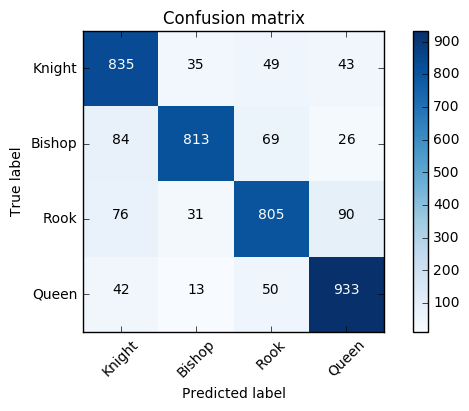

In [14]:
from helpers import plot_confusion_matrix

plot_confusion_matrix(conf, labels)

In [15]:
sess.close()